In [121]:
library('ggplot2')
library('patchwork')
library('data.table')
library('dplyr')
library('rgeos')
library('mapproj')
library('RColorBrewer')
library('ggvoronoi')
library('rjson')
library('cowplot')
library('gridExtra')
library('grid')
library('sets')
library('sp')
library('tidyr')
library('ggnewscale')
library('scales')
load("~/locator/data/cntrymap.Rdata")

In [122]:
pal = c('#235862','#e740b4','#ffccba','#54d705','#fcfcfc')
palgen = colorRampPalette(pal)
colgen = colorRamp(pal)
figdir = '/home/crehmann/public_html/locator-residuals/' # place to save figures to

pfdark=pal[3] 
pflight=pal[2]

agdark=pal[1]
aglight=pal[4]

Anopheles & Plasmodium empirical predictions

In [170]:
# error for ALL samples -

ag <- fread('data/anopheles_plasmodium/ag1000g_centroids.txt')
md <- fread('data/anopheles_plasmodium/ag1000g_v3_gambiae.txt')
ag <- merge(ag, md, on='sampleID')
ag <- ag[,c('x','y','kd_x','kd_y')]
ag[] <- lapply(ag, as.numeric)
ag$organism <- 'anopheles'
ag <- ag[ag$y < 25,]

pf <- fread('data/anopheles_plasmodium/pf7_centroids.txt')
md <- fread('data/anopheles_plasmodium/pf7_africa_QC.txt')
pf <- merge(pf, md, on='sampleID')
pf <- pf[,c('x','y','kd_x','kd_y')]
pf[] <- lapply(pf, as.numeric)
pf$organism <- 'plasmodium'

pd <- rbind(ag, pf)
tlocs <- as.matrix(pd[,c('x','y')])
plocs <- as.matrix(pd[,c('kd_x','kd_y')])
pd$error <- sapply(1:nrow(plocs),function(e) spDistsN1(t(as.matrix(plocs[e,])),
                   t(as.matrix(tlocs[e,])),longlat = TRUE))

summary <- pd %>% group_by_at(c('x', 'y', 'organism')) %>%
                  summarize(kd_x_mean = mean(kd_x),
                  kd_y_mean = mean(kd_y),
                  error = mean(error))

`summarise()` has grouped output by 'x', 'y'. You can override using the `.groups` argument.


In [124]:
# condense proximate Anopheles sampling locations in Cameroon

afgroup <- summary[summary$y < 10 & 
            summary$y > 4 &
            summary$x > 10 &
            summary$x < 15 &
            summary$organism == 'anopheles',]
summary <- summary[!(summary$y < 10 & 
            summary$y > 4 &
            summary$x > 10 &
            summary$x < 15 &
            summary$organism == 'anopheles'),]

mean <- colMeans(afgroup[,c('x','y','error','kd_x_mean','kd_y_mean')])

summary <- rbind(summary, data.table(x=mean['x'], y=mean['y'], error=mean['error'], kd_x_mean=mean['kd_x_mean'], kd_y_mean=mean['kd_y_mean'], organism='anopheles'))

afgroup <- summary[summary$y < 15 & 
            summary$y > 10 &
            summary$x > 10 &
            summary$x < 15 &
            summary$organism == 'anopheles',]
summary <- summary[!(summary$y < 15 & 
            summary$y > 10 &
            summary$x > 10 &
            summary$x < 15 &
            summary$organism == 'anopheles'),]

mean <- colMeans(afgroup[,c('x','y','error','kd_x_mean','kd_y_mean')])

summary <- rbind(summary, data.table(x=mean['x'], y=mean['y'], error=mean['error'], kd_x_mean=mean['kd_x_mean'], kd_y_mean=mean['kd_y_mean'], organism='anopheles'))

Regions defined for each Polygons



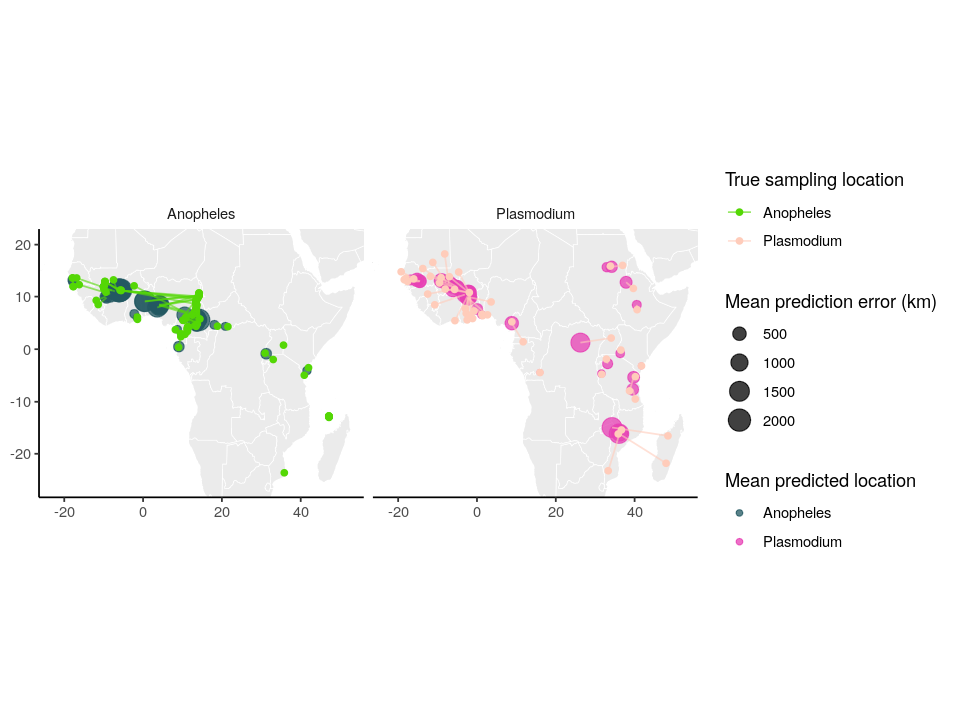

In [181]:
pred_plot <- ggplot()+theme_classic()+ labs(xlab='Longitude',ylab='Latitude',error='Mean prediction error') + 
            # plot map
            coord_map(projection = "mollweide",
                   xlim=c(min(na.omit(c(summary$kd_x_mean,summary$x)))-2.5,
                          max(na.omit(c(summary$kd_x_mean,summary$x)))+2.5),
                   ylim=c(min(na.omit(c(summary$kd_y_mean,summary$y)))-2.5,
                          max(na.omit(c(summary$kd_y_mean,summary$y)))+2.5))+
            geom_polygon(data=fortify(map),aes(x=long,y=lat,group=group),fill="#ebebeb",color="white",lwd=0.2)+
                            theme(axis.title = element_blank())+
            geom_point(summary, mapping=aes(x=kd_x_mean, y=kd_y_mean, group=organism, color=organism, size=error), alpha=0.75) +
            guides(size = guide_legend(title = "Mean prediction error (km)")) +
            scale_color_manual(name="Mean predicted location", values=c("anopheles"=agdark, "plasmodium"=pflight), labels=c("Anopheles","Plasmodium")) +

            new_scale_colour() +
            geom_point(summary, mapping=aes(x=x, y=y, group=organism, color=organism)) +
            scale_color_manual(name="True sampling location", values=c("anopheles"=aglight, "plasmodium"=pfdark), labels=c("Anopheles","Plasmodium")) +   
            geom_segment(summary, mapping=aes(x=x, y=y, xend=kd_x_mean, yend=kd_y_mean, group=organism, color=organism), alpha=0.6) +
            #scale_color_manual(values=c(aglight, pfdark), labels=NULL, name=NULL, guide="none") +
            
            facet_wrap(~organism, labeller = labeller(organism = c('anopheles'='Anopheles','plasmodium'='Plasmodium'))) + theme( strip.background = element_blank() )

pred_plot

In [182]:
agemperr <- pd[pd$organism=='anopheles',]$error
agd <- ggplot(mapping = aes(pd[pd$organism=='anopheles',]$error))+theme_classic()+
        geom_density(fill=aglight, color=agdark, alpha=0.5)+
        ylab('')+xlab('Anopheles prediction error')+
        theme(axis.ticks.y = element_blank(),
        axis.text.y = element_blank()) +scale_x_continuous(trans='log10')

pfemperr <- pd[pd$organism=='plasmodium',]$error
pfd <- ggplot(mapping = aes(pd[pd$organism=='plasmodium',]$error))+theme_classic()+
        geom_density(fill=pflight, color=pfdark, alpha=0.5)+
        ylab('')+xlab('Plasmodium prediction error')+
        theme(axis.ticks.y = element_blank(),
        axis.text.y = element_blank())+
        expand_limits(x=0, y=0)+scale_x_continuous(trans='log10')

In [183]:
print(c('mean Anopheles prediction error:', mean(pd[pd$organism=='anopheles',]$error)))
print(c('median Anopheles prediction error:',median(pd[pd$organism=='anopheles',]$error)))
print(c('mean Plasmodium prediction error:',mean(pd[pd$organism=='plasmodium',]$error)))
print(c('median Plasmodium prediction error:',median(pd[pd$organism=='plasmodium',]$error)))

[1] "mean Anopheles prediction error:" "130.315053796207"                
[1] "median Anopheles prediction error:" "12.8679762935302"                  
[1] "mean Plasmodium prediction error:" "203.083912081601"                 
[1] "median Plasmodium prediction error:" "8.18190153604581"                   


In [184]:
# pairwise correlation between great circle distance and angle vector between Anopheles and Plasmodium predictions

anopheles <- pd[pd$organism == 'anopheles',]
anopheles$xvector <- anopheles$kd_x - anopheles$x
anopheles$yvector <- anopheles$kd_y - anopheles$y
anopheles$sampleID <- seq(nrow(anopheles))
plasmodium <- pd[pd$organism == 'plasmodium',]
plasmodium$xvector <- plasmodium$kd_x - plasmodium$x
plasmodium$yvector <- plasmodium$kd_y - plasmodium$y
plasmodium$sampleID <- seq(nrow(plasmodium))

In [70]:
combs <- expand.grid(anopheles$sampleID, plasmodium$sampleID)

In [15]:

ag <- anopheles[combs$Var1,]
pf <- plasmodium[combs$Var2,]


In [17]:
aglocs <- as.matrix(ag[,c('x','y')])
pflocs <- as.matrix(pf[,c('x','y')])
dists <- sapply(1:nrow(aglocs), function(e) spDistsN1(t(as.matrix(aglocs[e,])),
                                                      t(as.matrix(pflocs[e,])), longlat=TRUE))

In [18]:
hypot <- function(x, y) { return(sqrt(x**2 + y**2)) }

In [19]:
xvector <- ag[,'xvector'] + pf[,'xvector']
yvector <- ag[,'yvector'] + pf[,'yvector']
summags <- hypot(xvector, yvector)

In [33]:
N <- sample(length(dists), 100000)

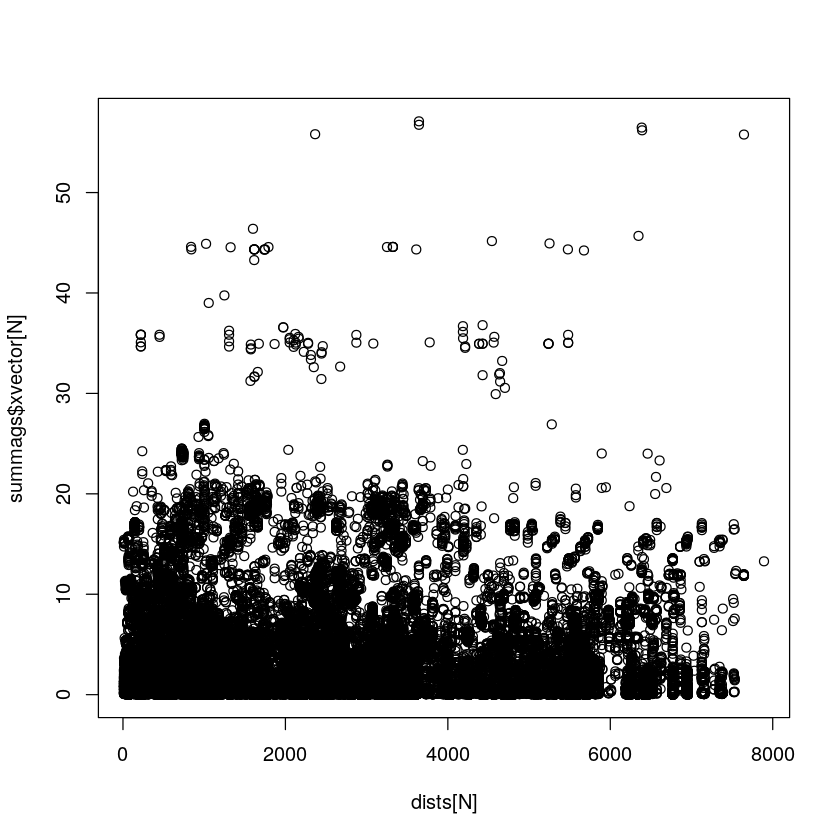

In [34]:
plot(dists[N], summags$xvector[N])

In [36]:
T <- cor.test(dists, summags$xvector, method='spearman')
T

Warning message in cor.test.default(dists, summags$xvector, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  dists and summags$xvector
S = 4.2064e+20, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.07725337 


In [30]:
Null <- cor.test(sample(dists), summags$xvector)
Null


	Pearson's product-moment correlation

data:  sample(dists) and summags$xvector
t = -0.29001, df = 13281486, p-value = 0.7718
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.0006173814  0.0004582284
sample estimates:
          cor 
-7.957654e-05 


In [267]:
anopheles['anopheles1',]

ERROR: Error in `[.data.table`(anopheles, "anopheles1", ): When i is a data.table (or character vector), the columns to join by must be specified using 'on=' argument (see ?data.table), by keying x (i.e. sorted, and, marked as sorted, see ?setkey), or by sharing column names between x and i (i.e., a natural join). Keyed joins might have further speed benefits on very large data due to x being sorted in RAM.


In [185]:
# residual correlations

corr = fread('data/anopheles_plasmodium/unweighted_anopheles_plasmodium_correlation.txt')
corr$type = rep('Spatial pairs', nrow(corr))
perm = fread('data/anopheles_plasmodium/unweighted_anopheles_plasmodium_permutation.txt')
perm$type = rep('Random pairs', nrow(perm))
corr_perm = rbind(corr, perm)
corr_perm$Mag <- corr_perm$mag

In [186]:
mean(corr$vector)

[1] 0.2838626

In [187]:
mean(corr$angle)

[1] 0.1632553

In [188]:
mean(corr$mag)

[1] 0.9238922

In [189]:
mean(perm$mag)
mean(perm$angle)
mean(perm$vector)

[1] 0.0006383497

[1] 0.0005202288

[1] 0.002444513

In [190]:
w <- wilcox.test(corr_perm[corr_perm$type == 'Spatial pairs',]$angle, corr_perm[corr_perm$type == 'Random pairs',]$angle)
w$p.value

[1] 0

In [191]:
w <- wilcox.test(corr_perm[corr_perm$type == 'Spatial pairs',]$vector, corr_perm[corr_perm$type == 'Random pairs',]$vector)
w$p.value

[1] 0

In [192]:
w <- wilcox.test(corr_perm[corr_perm$type == 'Spatial pairs',]$mag, corr_perm[corr_perm$type == 'Random pairs',]$mag)
w$p.value

[1] 0

In [193]:
print(paste('vector correlation:', mean(corr_perm[corr_perm$type == 'Spatial pairs',]$vector), '+/-', sd(corr_perm[corr_perm$type == 'Spatial pairs',]$vector)))
print(paste('angle correlation:',mean(corr_perm[corr_perm$type == 'Spatial pairs',]$angle), '+/-', sd(corr_perm[corr_perm$type == 'Spatial pairs',]$angle)))
print(paste('magnitude correlation:',mean(corr_perm[corr_perm$type == 'Spatial pairs',]$Mag), '+/-', sd(corr_perm[corr_perm$type == 'Spatial pairs',]$Mag)))

[1] "vector correlation: 0.283862604957722 +/- 0.0383405155862378"
[1] "angle correlation: 0.163255326584704 +/- 0.0412649893556697"
[1] "magnitude correlation: 0.923892159455995 +/- 0.00418627947537256"


In [194]:
vector <- ggplot()+theme_classic()+
    geom_boxplot(corr_perm, lwd=0.1, outlier.size=0.1, mapping=aes(x=vector, fill=reorder(type, -vector)), show.legend = FALSE)+coord_flip()+
    scale_fill_manual(name="Type", values=c("Spatial pairs"=aglight, "Random pairs"=pfdark))+
    ylab('Vector correlation')+xlab('')+theme(
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank())

angle <- ggplot()+theme_classic()+
    geom_boxplot(corr_perm, lwd=0.1, outlier.size=0.1, mapping=aes(x=angle, fill=reorder(type, -vector)), show.legend = FALSE)+coord_flip()+
    scale_fill_manual(name="Type", values=c("Spatial pairs"=aglight, "Random pairs"=pfdark))+
    ylab('Angle correlation')+xlab('')+theme(
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank())

magn <- ggplot()+theme_classic()+
    geom_boxplot(corr_perm, lwd=0.1, outlier.size=0.25, mapping=aes(x=Mag, fill=reorder(type, -vector)))+coord_flip()+
    scale_fill_manual(name="Type", values=c("Spatial pairs"=aglight, "Random pairs"=pfdark))+
    ylab('Magnitude correlation')+xlab('')+theme(
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank())

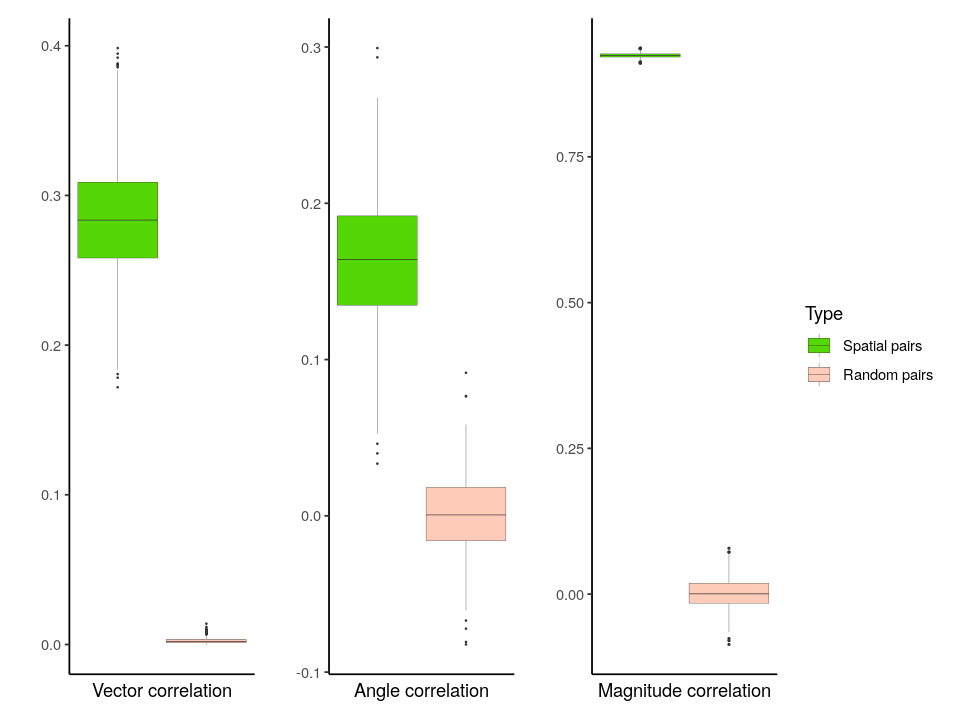

In [195]:
vector | angle | magn

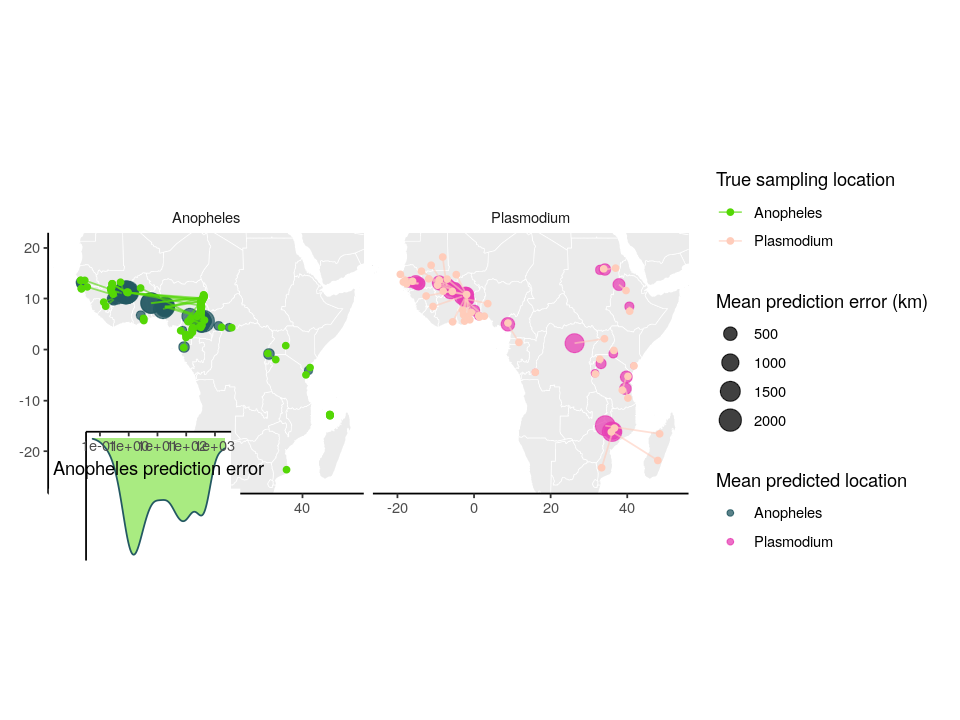

In [211]:
mapplot <- pred_plot + inset_element(agd,
                        left = 0.001, bottom = 0.3, right = 0.3, top = 0.2)# +
                       #inset_element(pfd,
                        #left=1, bottom=0.01, right=0.5, top=0.6)
mapplot

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


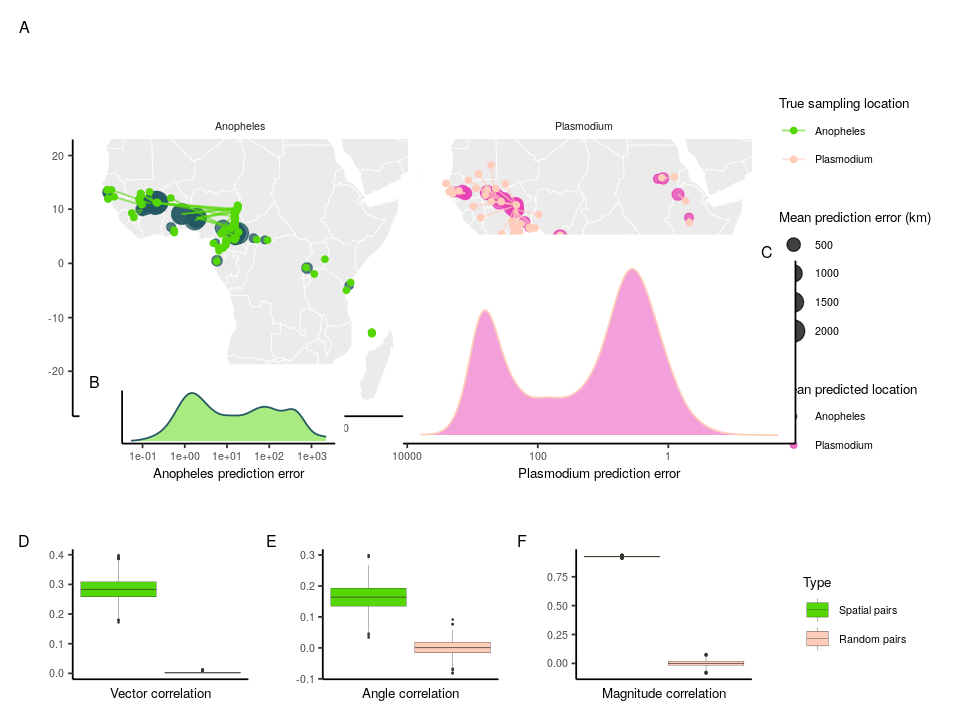

In [198]:
#errdist <- agd / pfd
mapplot <- pred_plot + inset_element(agd,
                        left = 0.01, bottom = 0.01, right = 0.4, top = 0.3) +
                       inset_element(pfd,
                        left=1, bottom=0.01, right=0.5, top=0.6)

corrs <- vector + angle + magn + plot_layout(ncol=3)
predplt <- mapplot / corrs + plot_layout(heights=c(10, 3)) + 
            plot_annotation(tag_levels = 'A') & theme(text=element_text(size=8))
options(repr.plot.width = 8, repr.plot.height = 6)
predplt
ggsave(file.path(figdir,'empirical_anopheles_plasmodium.pdf'), width = 6.5, height = 6, units='in')

Weighted Locator runs on Anopheles and plasmodium:

In [152]:
# error for ALL samples -

ag <- fread('data/anopheles_plasmodium/ag1000g_weighted_centroids.txt')
md <- fread('data/anopheles_plasmodium/ag1000g_v3_gambiae.txt')
ag <- merge(ag, md, on='sampleID')
ag <- ag[,c('x','y','kd_x','kd_y')]
ag[] <- lapply(ag, as.numeric)
ag$organism <- 'anopheles'
ag <- ag[ag$y < 25,]

pf <- fread('data/anopheles_plasmodium/pf7_africa_weighted_centroids.txt')
md <- fread('data/anopheles_plasmodium/pf7_africa_QC.txt')
pf <- merge(pf, md, on='sampleID')
pf <- pf[,c('x','y','kd_x','kd_y')]
pf[] <- lapply(pf, as.numeric)
pf$organism <- 'plasmodium'

pd <- rbind(ag, pf)
tlocs <- as.matrix(pd[,c('x','y')])
plocs <- as.matrix(pd[,c('kd_x','kd_y')])
pd$error <- sapply(1:nrow(plocs),function(e) spDistsN1(t(as.matrix(plocs[e,])),
                   t(as.matrix(tlocs[e,])),longlat = TRUE))

summary <- pd %>% group_by_at(c('x', 'y', 'organism')) %>%
                  summarize(kd_x_mean = mean(kd_x),
                  kd_y_mean = mean(kd_y),
                  error = mean(error))

`summarise()` has grouped output by 'x', 'y'. You can override using the `.groups` argument.


In [153]:
# condense proximate Anopheles sampling locations in Cameroon

afgroup <- summary[summary$y < 10 & 
            summary$y > 4 &
            summary$x > 10 &
            summary$x < 15 &
            summary$organism == 'anopheles',]
summary <- summary[!(summary$y < 10 & 
            summary$y > 4 &
            summary$x > 10 &
            summary$x < 15 &
            summary$organism == 'anopheles'),]

mean <- colMeans(afgroup[,c('x','y','error','kd_x_mean','kd_y_mean')])

summary <- rbind(summary, data.table(x=mean['x'], y=mean['y'], error=mean['error'], kd_x_mean=mean['kd_x_mean'], kd_y_mean=mean['kd_y_mean'], organism='anopheles'))

afgroup <- summary[summary$y < 15 & 
            summary$y > 10 &
            summary$x > 10 &
            summary$x < 15 &
            summary$organism == 'anopheles',]
summary <- summary[!(summary$y < 15 & 
            summary$y > 10 &
            summary$x > 10 &
            summary$x < 15 &
            summary$organism == 'anopheles'),]

mean <- colMeans(afgroup[,c('x','y','error','kd_x_mean','kd_y_mean')])

summary <- rbind(summary, data.table(x=mean['x'], y=mean['y'], error=mean['error'], kd_x_mean=mean['kd_x_mean'], kd_y_mean=mean['kd_y_mean'], organism='anopheles'))

In [154]:
pred_plot <- ggplot()+theme_classic()+ labs(xlab='Longitude',ylab='Latitude',error='Mean prediction error') + 
            # plot map
            coord_map(projection = "mollweide",
                   xlim=c(min(na.omit(c(summary$kd_x_mean,summary$x)))-2.5,
                          max(na.omit(c(summary$kd_x_mean,summary$x)))+2.5),
                   ylim=c(min(na.omit(c(summary$kd_y_mean,summary$y)))-2.5,
                          max(na.omit(c(summary$kd_y_mean,summary$y)))+2.5))+
            geom_polygon(data=fortify(map),aes(x=long,y=lat,group=group),fill="#ebebeb",color="white",lwd=0.2)+
                            theme(axis.title = element_blank())+
            geom_point(summary, mapping=aes(x=x, y=y, group=organism, color=organism)) +
            scale_color_manual(name="True sampling location", values=c("anopheles"=aglight, "plasmodium"=pfdark), labels=c("Anopheles","Plasmodium")) +   
            new_scale_colour() +
            geom_segment(summary, mapping=aes(x=x, y=y, xend=kd_x_mean, yend=kd_y_mean, group=organism, color=organism), alpha=0.6) +
            scale_color_manual(values=c(aglight, pfdark), labels=NULL, name=NULL, guide="none") +
            new_scale_colour() +
            geom_point(summary, mapping=aes(x=kd_x_mean, y=kd_y_mean, group=organism, color=organism, size=error), alpha=0.75) +
            guides(size = guide_legend(title = "Mean prediction error (km)")) +
            scale_color_manual(name="Mean predicted location", values=c("anopheles"=agdark, "plasmodium"=pflight), labels=c("Anopheles","Plasmodium"))

Regions defined for each Polygons



In [155]:
mean(pd[pd$organism=='anopheles',]$error)
median(pd[pd$organism=='anopheles',]$error)
mean(pd[pd$organism=='plasmodium',]$error)
median(pd[pd$organism=='plasmodium',]$error)

[1] 116.3111

[1] 13.16621

[1] 151.242

[1] 6.927165

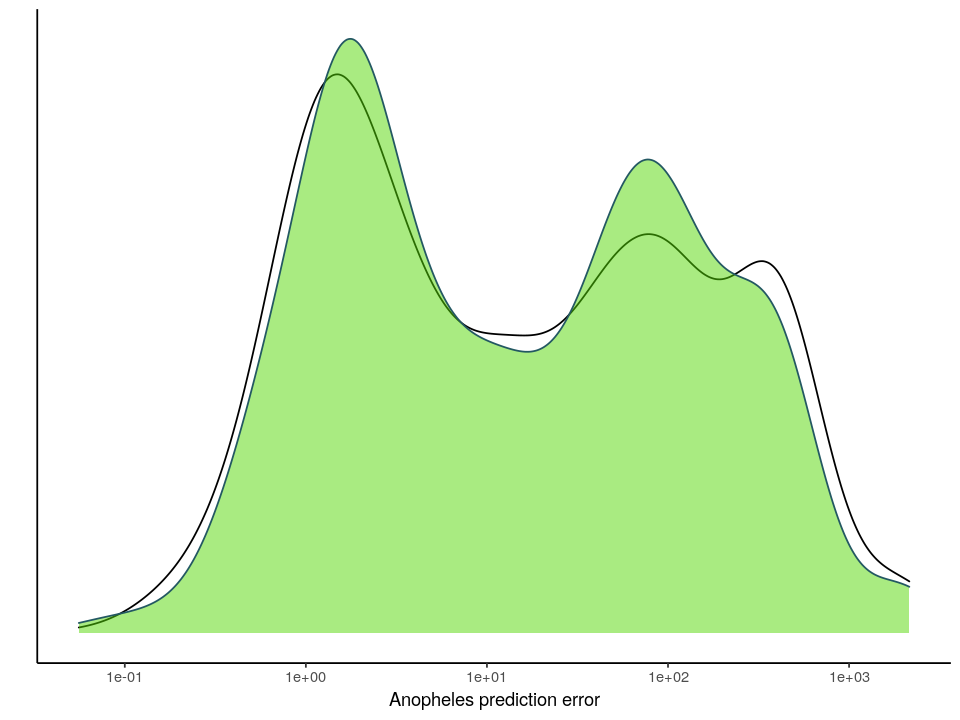

In [156]:
agd <- ggplot(mapping = aes(pd[pd$organism=='anopheles',]$error))+theme_classic()+
        geom_density(aes(agemperr)) +
        geom_density(fill=aglight, color=agdark, alpha=0.5)+
        ylab('')+xlab('Anopheles prediction error')+
        theme(axis.ticks.y = element_blank(),
        axis.text.y = element_blank()) +scale_x_continuous(trans='log10')

agxlim <- layer_scales(agd)$x$get_limits()
agylim <- layer_scales(agd)$y$get_limits()
agd

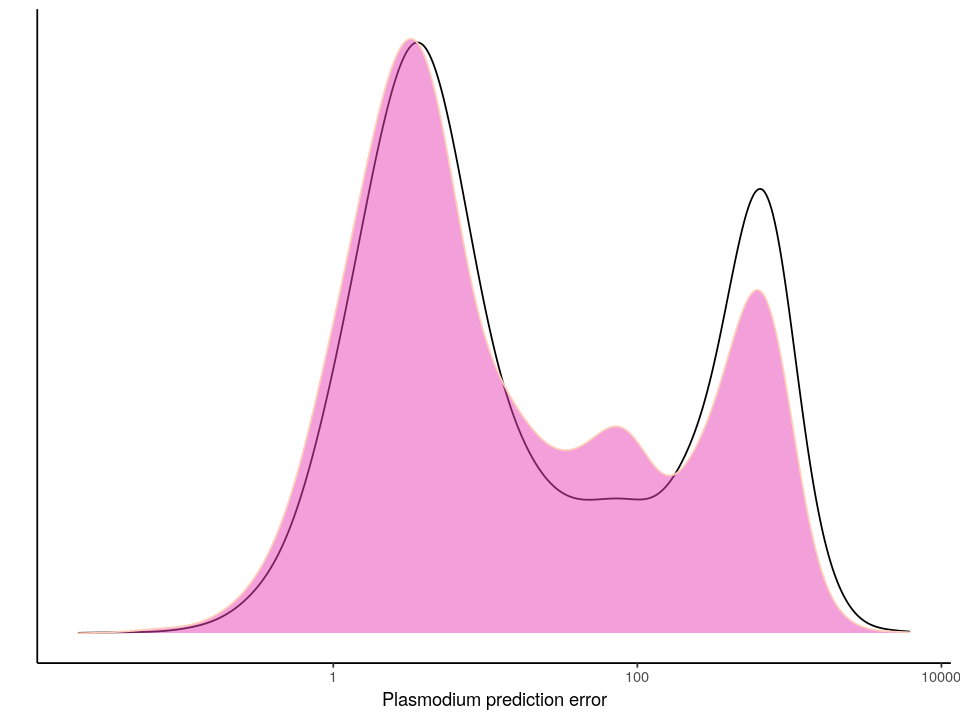

In [157]:
pfd <- ggplot(mapping = aes(pd[pd$organism=='plasmodium',]$error))+theme_classic()+
        geom_density(aes(pfemperr)) + 
        geom_density(fill=pflight, color=pfdark, alpha=0.5)+
        ylab('')+xlab('Plasmodium prediction error')+
        theme(axis.ticks.y = element_blank(),
        axis.text.y = element_blank())+scale_x_continuous(trans='log10')
       # expand_limits(x=0, y=0)#+
        #scale_y_continuous(breaks=c(0, 5, 10, 15, 20))
pfxlim <- layer_scales(pfd)$x$get_limits()
pfylim <- layer_scales(pfd)$y$get_limits()
pfd

In [161]:
# residual correlations

corr = fread('data/anopheles_plasmodium/weighted_anopheles_plasmodium_correlation.txt')
corr$type = rep('Spatial pairs', nrow(corr))
perm = fread('data/anopheles_plasmodium/weighted_anopheles_plasmodium_permutation.txt')
perm$type = rep('Random pairs', nrow(perm))
corr_perm = rbind(corr, perm)
corr_perm$Mag <- corr_perm$mag

In [162]:
w <- wilcox.test(corr_perm[corr_perm$type == 'Spatial pairs',]$angle, corr_perm[corr_perm$type == 'Random pairs',]$angle)
w$p.value

[1] 5.473202e-281

In [163]:
w <- wilcox.test(corr_perm[corr_perm$type == 'Spatial pairs',]$vector, corr_perm[corr_perm$type == 'Random pairs',]$vector)
w$p.value

[1] 0

In [164]:
w <- wilcox.test(corr_perm[corr_perm$type == 'Spatial pairs',]$mag, corr_perm[corr_perm$type == 'Random pairs',]$mag)
w$p.value

[1] 0

In [165]:
print(paste('vector correlation:', mean(corr_perm[corr_perm$type == 'Spatial pairs',]$vector), '+/-', sd(corr_perm[corr_perm$type == 'Spatial pairs',]$vector)))
print(paste('angle correlation:',mean(corr_perm[corr_perm$type == 'Spatial pairs',]$angle), '+/-', sd(corr_perm[corr_perm$type == 'Spatial pairs',]$angle)))
print(paste('magnitude correlation:',mean(corr_perm[corr_perm$type == 'Spatial pairs',]$Mag), '+/-', sd(corr_perm[corr_perm$type == 'Spatial pairs',]$Mag)))

[1] "vector correlation: 0.0848932677364322 +/- 0.0352944126956115"
[1] "angle correlation: 0.0841811991176844 +/- 0.0406420773140114"
[1] "magnitude correlation: 0.910777866290311 +/- 0.00572710631725292"


In [166]:
vector <- ggplot()+theme_classic()+
    geom_boxplot(corr_perm, lwd=0.1, outlier.size=0.1, mapping=aes(x=vector, fill=reorder(type, -vector)), show.legend = FALSE)+coord_flip()+
    scale_fill_manual(name="Type", values=c("Spatial pairs"=aglight, "Random pairs"=pfdark))+
    ylab('Vector correlation')+xlab('')+theme(
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank())

angle <- ggplot()+theme_classic()+
    geom_boxplot(corr_perm, lwd=0.1, outlier.size=0.1, mapping=aes(x=angle, fill=reorder(type, -vector)), show.legend = FALSE)+coord_flip()+
    scale_fill_manual(name="Type", values=c("Spatial pairs"=aglight, "Random pairs"=pfdark))+
    ylab('Angle correlation')+xlab('')+theme(
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank())

magn <- ggplot()+theme_classic()+
    geom_boxplot(corr_perm, lwd=0.1, outlier.size=0.25, mapping=aes(x=Mag, fill=reorder(type, -vector)))+coord_flip()+
    scale_fill_manual(name="Type", values=c("Spatial pairs"=aglight, "Random pairs"=pfdark))+
    ylab('Magnitude correlation')+xlab('')+theme(
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank())

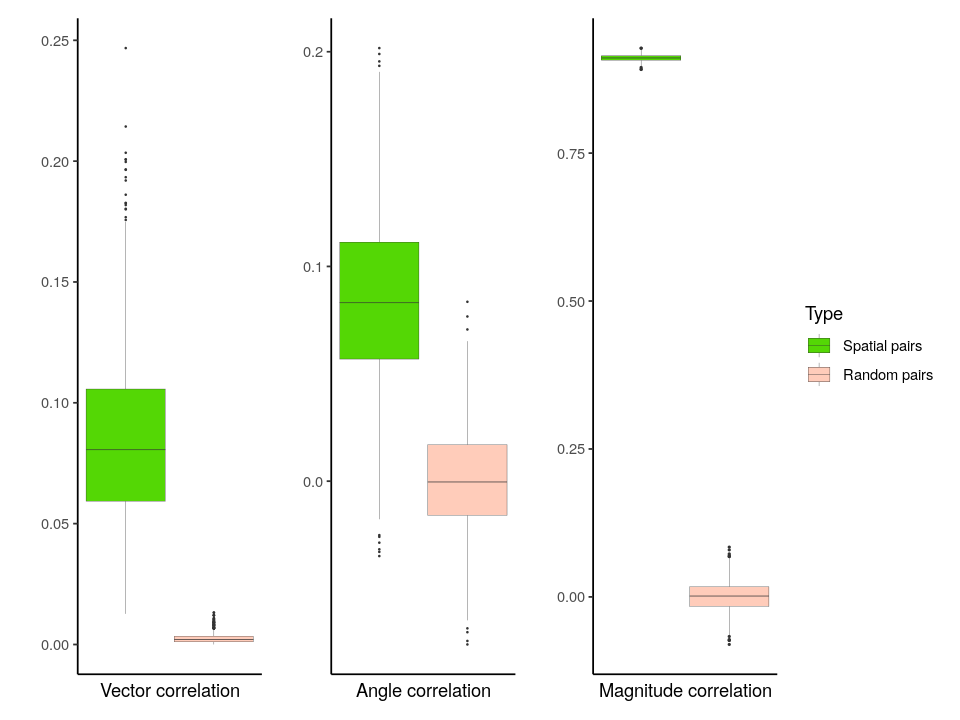

In [167]:
vector | angle | magn

In [168]:
mean(pd[pd$organism=='anopheles',]$error)
median(pd[pd$organism=='anopheles',]$error)
mean(pd[pd$organism=='plasmodium',]$error)
median(pd[pd$organism=='plasmodium',]$error)

[1] 116.3111

[1] 13.16621

[1] 151.242

[1] 6.927165

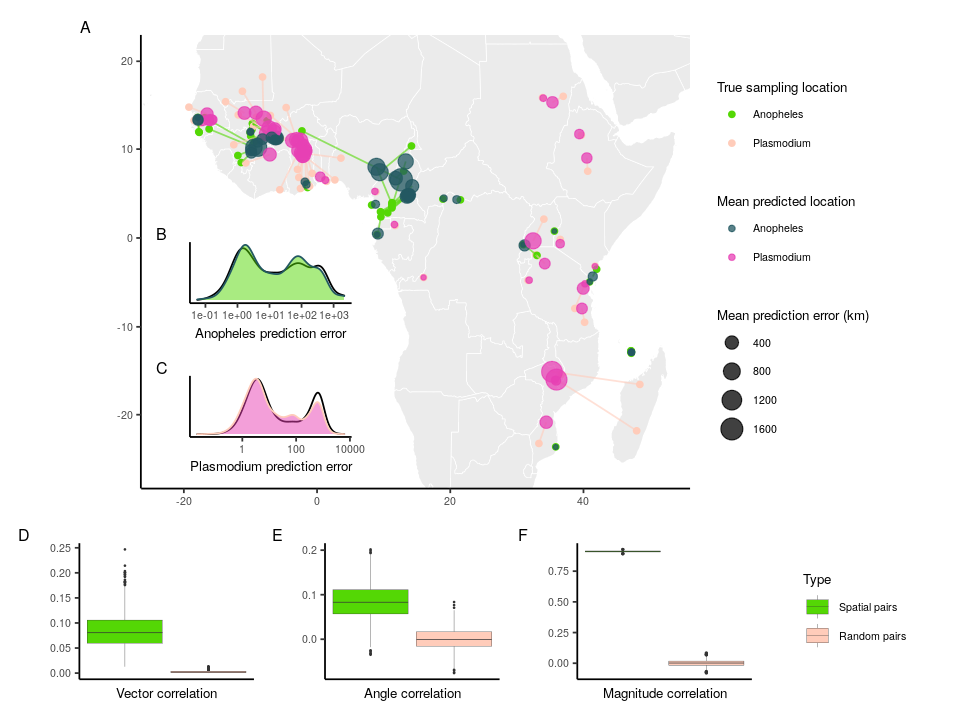

In [169]:
errdist <- agd / pfd
mapplot <- pred_plot + inset_element(errdist,
                        left = 0.01, bottom = 0.01, right = 0.4, top = 0.6)

corrs <- vector + angle + magn + plot_layout(ncol=3)
predplt <- mapplot / corrs + plot_layout(heights=c(10, 3)) + 
            plot_annotation(tag_levels = 'A') & theme(text=element_text(size=8))
options(repr.plot.width = 8, repr.plot.height = 6)
predplt
ggsave(file.path(figdir,'weighted_anopheles_plasmodium.pdf'), width = 6.5, height = 6, units='in')

Slimulated skewed training sets

In [207]:
df <- fread('data/biased_training/all_skew_predlocs.txt')
df$skew_scale <- rescale(df$skew)
df$sigma_scale <- rescale(df$sigma)

In [208]:
xfit <- glm(xerr ~ 0 + skew_scale, data=df[df$sigma==1,])
summary(xfit)


Call:
glm(formula = xerr ~ 0 + skew_scale, data = df[df$sigma == 1, 
    ])

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-16.2947   -2.1223   -0.1457    2.0151   15.4776  

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
skew_scale  0.38384    0.03111   12.34   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 9.741878)

    Null deviance: 262945  on 26840  degrees of freedom
Residual deviance: 261462  on 26839  degrees of freedom
AIC: 137271

Number of Fisher Scoring iterations: 2


In [167]:
xfit <- glm(xerr ~ 0 + skew_scale + sigma_scale, data=df)
summary(xfit)


Call:
glm(formula = xerr ~ 0 + skew_scale + sigma_scale, data = df)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-16.1291   -1.5036   -0.0998    1.3781   15.6433  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
skew_scale   0.12810    0.01607   7.969 1.61e-15 ***
sigma_scale  0.09011    0.01580   5.704 1.17e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 5.964198)

    Null deviance: 643896  on 107690  degrees of freedom
Residual deviance: 642273  on 107688  degrees of freedom
AIC: 497925

Number of Fisher Scoring iterations: 2


In [168]:
yfit <- glm(yerr ~ 0 + skew_scale + sigma_scale, data=df)
summary(yfit)


Call:
glm(formula = yerr ~ 0 + skew_scale + sigma_scale, data = df)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-16.1346   -1.4403   -0.0046    1.4156   15.4739  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
skew_scale  -0.01872    0.01609  -1.164   0.2445  
sigma_scale  0.03937    0.01581   2.491   0.0128 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 5.972881)

    Null deviance: 643247  on 107690  degrees of freedom
Residual deviance: 643208  on 107688  degrees of freedom
AIC: 498082

Number of Fisher Scoring iterations: 2


In [180]:
unweighted_sumdf <- df %>% group_by_at(c('sigma','skew','rep')) %>%
            summarize(xerr_mean = mean(xerr),
                      yerr_mean = mean(yerr),
                      err_mean = mean(err))

`summarise()` has grouped output by 'sigma', 'skew'. You can override using the `.groups` argument.


In [183]:
unweighted_error <- median(unweighted_sumdf[unweighted_sumdf$sigma == 1 & unweighted_sumdf$skew == 0.9,]$err_mean)
unweighted_xerr <- mean(unweighted_sumdf[unweighted_sumdf$sigma == 1 & unweighted_sumdf$skew == 0.9,]$xerr_mean)
unweighted_yerr <- mean(unweighted_sumdf[unweighted_sumdf$sigma == 1 & unweighted_sumdf$skew == 0.9,]$yerr_mean)

In [184]:
unweighted_error

[1] 4.373795

In [60]:
# example training sets
ts5 = fread('data/biased_training/sigma_1_bias_0_run_0_uniform_ts.txt')
ts6 = fread('data/biased_training/sigma_1_bias_0_run_0_skew_0.6_ts.txt')
ts7 = fread('data/biased_training/sigma_1_bias_0_run_0_skew_0.7_ts.txt')
ts8 = fread('data/biased_training/sigma_1_bias_0_run_0_skew_0.8_ts.txt')
ts9 = fread('data/biased_training/sigma_1_bias_0_run_0_skew_0.9_ts.txt')

In [63]:
tsplot <- function(ts, titl) {
    plot = ggplot()+theme_bw()+
            labs(title=titl)+
            geom_point(ts, mapping=aes(x=x, y=y), size=0.001)+
            ylab('')+xlab('')+
            scale_x_continuous(limits=c(0, 50), breaks=c(0, 25, 50))+
            scale_y_continuous(limits=c(0, 50), breaks=c(0, 25, 50))+
            coord_fixed()
    return(plot)
    }

# skewed training sets
p5 <- tsplot(ts5, '0.5')
p6 <- tsplot(ts6, '0.6')
p7 <- tsplot(ts7, '0.7')
p8 <- tsplot(ts8, '0.8')
p9 <- tsplot(ts9, '0.9')

spal <- palgen(4)

# error
xax <- ggplot()+theme_classic()+
        geom_boxplot(unweighted_sumdf,lwd=0.1, outlier.size=0.001,  mapping=aes(x=factor(skew), y=xerr_mean, fill=factor(sigma)))+
        scale_fill_manual(name="Dispersal rate", values=rev(spal))+ylab('Mean x-axis error')+xlab('Training set bias')
yax <- ggplot()+theme_classic()+
        geom_boxplot(unweighted_sumdf, lwd=0.1, outlier.size=0.001,  mapping=aes(x=factor(skew), y=yerr_mean, fill=factor(sigma)))+
        scale_fill_manual(name="Dispersal rate", values=rev(spal))+ylab('Mean y-axis error')+xlab('Training set bias')
mgn <- ggplot()+theme_classic()+
        geom_boxplot(unweighted_sumdf, lwd=0.1, outlier.size=0.001,  mapping=aes(x=factor(skew), y=err_mean, fill=factor(sigma)))+
        scale_fill_manual(name="Dispersal rate", values=rev(spal))+ylab('Mean prediction error')+xlab('Training set bias')

Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”


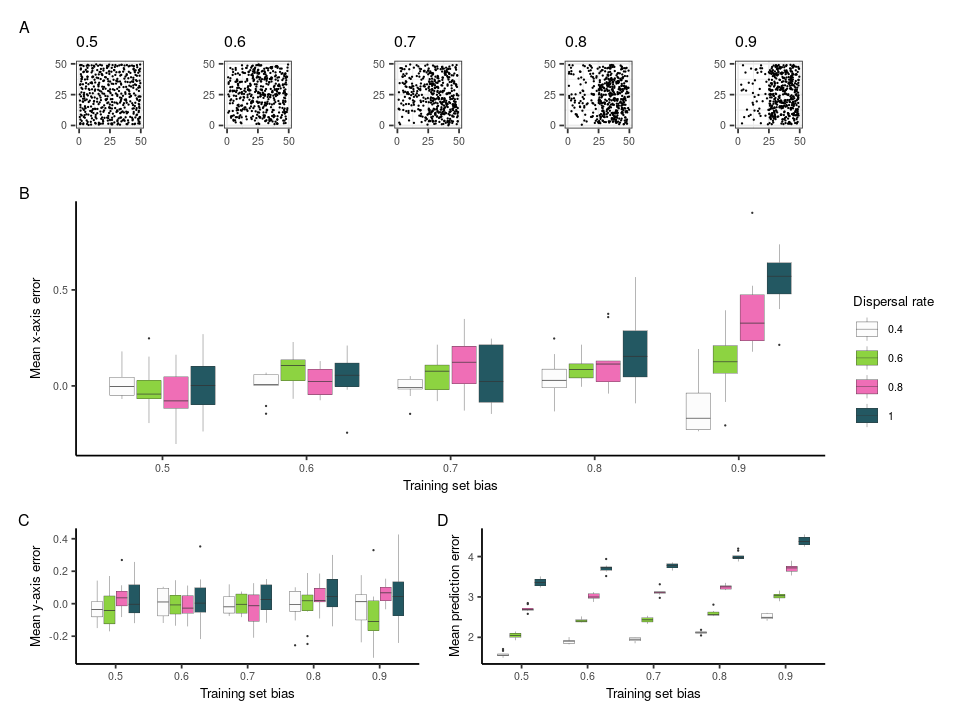

In [64]:
ts <- p5 | p6 | p7 | p8 | p9
fig <- ts / xax / (yax | mgn) +
  plot_layout(guides = 'collect', heights=c(2, 7.5, 4)) & theme(text=element_text(size=8))
for (n in c(2, 3, 4, 5)){
    fig[[1]][[n]] <- fig[[1]][[n]]+plot_layout(tag_level = 'new')
    }
fig + plot_annotation(tag_level='A')
ggsave(file.path(figdir,'sigma_skewed_training_set.pdf'), width = 6.5, height = 6, units='in')

Predlocs with weights!

In [189]:
df <- fread('data/biased_training/weighted_all_skew_predlocs.txt')
df$skew_scaled <- rescale(df$skew, to=c(1/3, 1))
df$lm <- round(df$lm, 6)

In [190]:
lmCoefficient <- function(skew_scaled, xerr) {
    if (length(skew_scaled) > 0) {
        sumres <- summary(lm(xerr ~ 0 + skew_scaled))
        return(sumres$coefficient[1])
    }
    else { return(NA) }
}
    
lmSignificance <- function(skew_scaled, xerr) {
    if (length(skew_scaled) > 0) {
        sumres <- summary(lm(xerr ~ 0 + skew_scaled))
        if (is.numeric(sumres$fstatistic[1L])) {
            return(pf(sumres$fstatistic[1L], sumres$fstatistic[2L], sumres$fstatistic[3L], lower.tail = FALSE))
        }
         else { return(NA) }
    }
    else { return(NA) }
}

In [191]:
# linear relationships?

lmdf <- df %>% group_by_at(c('bw','lm')) %>%
         summarize(R = lmCoefficient(skew_scaled, xerr),
                   p = lmSignificance(skew_scaled, xerr))

ylmdf <- df %>% group_by_at(c('bw','lm')) %>%
         summarize(R = lmCoefficient(skew_scaled, yerr),
                   p = lmSignificance(skew_scaled, yerr))

err_df <- df %>% group_by_at(c('bw','lm','skew')) %>%
         summarize(skew = mean(skew),
                   xerr_mean = mean(xerr),
                   xerr_median = median(xerr),
                   err_mean = mean(err),
                   err_median = median(err),
                   yerr_mean = mean(yerr))

sum_df <- df %>% group_by_at(c('bw','lm','skew','rep')) %>%
         summarize(skew = mean(skew),
                   xerr_mean = mean(xerr),
                   xerr_median = median(xerr),
                   err_mean = mean(err),
                   err_median = median(err),
                   yerr_mean = mean(yerr))

`summarise()` has grouped output by 'bw'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'bw'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'bw', 'lm'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'bw', 'lm', 'skew'. You can override using the `.groups` argument.


In [192]:
err <- ggplot(err_df[err_df$skew == 0.9,], aes(x=bw, y=factor(lm), fill=err_mean, width=0.5, height=0.1)) + theme_classic() + 
            geom_tile(height=1) + scale_fill_viridis_c(name="Mean\nerror") + ylab('')+xlab('Bandwidth')+
            theme(legend.key.width = unit(dev.size()[1] / 15, "line"),
                         legend.key.size = unit(0.75,"line"))

xerr <- ggplot(err_df[err_df$skew == 0.9,], aes(x=bw, y=factor(lm), fill=xerr_mean, width=0.5, height=0.1)) + theme_classic() + 
            geom_tile(height=1) + scale_fill_viridis_c(name="Mean\nx-axis\nerror")+ylab('Lambda')+xlab('Bandwidth')+
            theme(legend.key.width = unit(dev.size()[1] / 15, "line"),
                         legend.key.size = unit(0.75,"line"))

yerr <- ggplot(err_df[err_df$skew == 0.9,], aes(x=bw, y=factor(lm), fill=yerr_mean, width=0.5, height=0.1)) + theme_classic() + 
            geom_tile(height=1) + scale_fill_viridis_c(name="Mean\ny-axis\nerror")+ylab('')+xlab('Bandwidth')+
            theme(legend.key.width = unit(dev.size()[1] / 15, "line"),
                         legend.key.size = unit(0.75,"line"))

Rval <- ggplot(lmdf, aes(x=bw, y=factor(lm), fill=R)) + theme_classic() + geom_tile(height=1) + scale_fill_viridis_c()+ ylab('Lambda')+xlab('Bandwidth')
sig <- ggplot(lmdf, aes(x=bw, y=factor(lm), fill=p)) + theme_classic() + geom_tile(height=1) + scale_fill_viridis_c()+ ylab('Lambda')+xlab('Bandwidth')

yRval <- ggplot(ylmdf, aes(x=bw, y=factor(lm), fill=R)) + theme_classic() + geom_tile(height=1) + scale_fill_viridis_c()+ ylab('Lambda')+xlab('Bandwidth')
ysig <- ggplot(ylmdf, aes(x=bw, y=factor(lm), fill=p)) + theme_classic() + geom_tile(height=1) + scale_fill_viridis_c()+ ylab('Lambda')+xlab('Bandwidth')

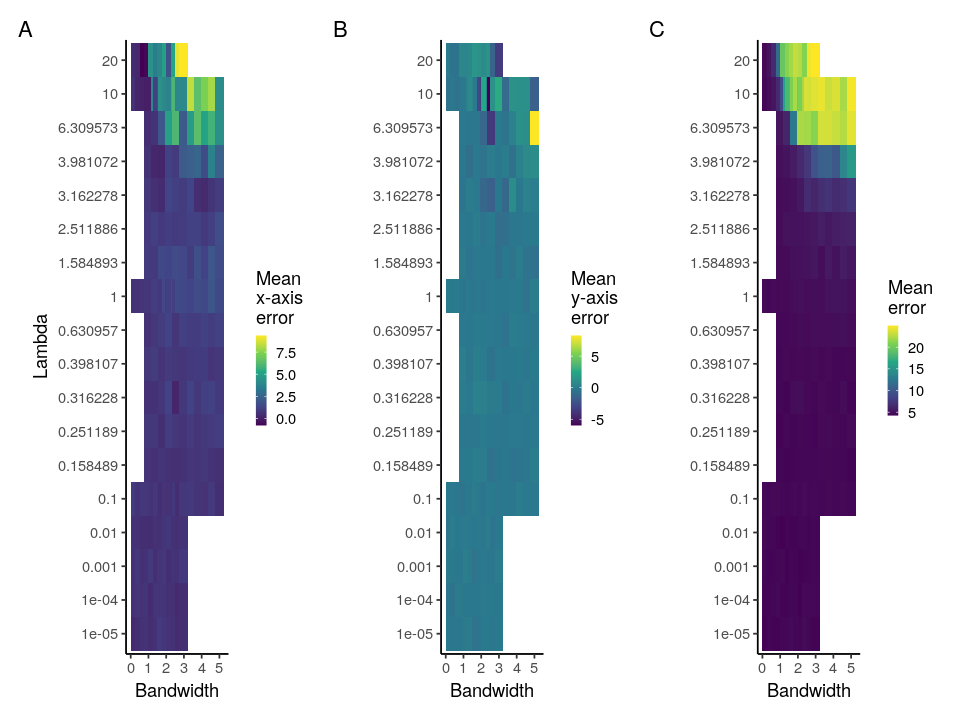

In [193]:
(xerr + yerr + err) + plot_annotation(tag_level='A') 
ggsave(file.path(figdir,'weight_grid_search.pdf'), width = 6.5, height = 2, units='in')

In [194]:
bw = 0.25
lam = 1e-5

In [195]:
df <- merge(err_df, lmdf, on=c('bw','lm'))

In [196]:
xdf <- df[df$skew == 0.9,]
xdf <- xdf[xdf$err_mean <= unweighted_error,]

In [197]:
rescaled_unwsumdf <- unweighted_sumdf[unweighted_sumdf$skew > 0.5 & unweighted_sumdf$sigma == 1,]
rescaled_unwsumdf <- rescaled_unwsumdf[,c('skew','rep','xerr_mean','err_mean','yerr_mean')]
rescaled_unwsumdf$weight <- 0    
weighted_df <- sum_df[sum_df$bw == bw & sum_df$lm == lam,]
weighted_df <- weighted_df[,c('skew','rep','xerr_mean','err_mean','yerr_mean')]
weighted_df$weight <- 1
comp_df <- rbind(rescaled_unwsumdf, weighted_df)

xplot <- ggplot()+theme_classic()+
            geom_boxplot(comp_df, lwd=0.1, mapping=aes(x=factor(skew), y=xerr_mean, fill=factor(weight))) + 
            scale_fill_manual(name='', values=c(spal[4], spal[2]), labels=c('Unweighted','Weighted'))+ylab('Mean x-axis error')+xlab('Training set bias')
yplot <- ggplot()+theme_classic()+
            geom_boxplot(comp_df, lwd=0.1, mapping=aes(x=factor(skew), y=yerr_mean, fill=factor(weight))) + 
            scale_fill_manual(name='', values=c(spal[4], spal[2]), labels=c('Unweighted','Weighted'))+ylab('Mean y-axis error')+xlab('Training set bias')
eplot <- ggplot()+theme_classic()+
            geom_boxplot(comp_df, lwd=0.1, mapping=aes(x=factor(skew), y=err_mean, fill=factor(weight))) + 
            scale_fill_manual(name='', values=c(spal[4], spal[2]), labels=c('Unweighted','Weighted'))+ylab('Mean error')+xlab('Training set bias')

xR <- lmdf[lmdf$bw == bw & lmdf$lm == lam,]$R
xp<- lmdf[lmdf$bw == bw & lmdf$lm == lam,]$p

yR <- ylmdf[ylmdf$bw == bw & ylmdf$lm == lam,]$R
yp<- ylmdf[ylmdf$bw == bw & ylmdf$lm == lam,]$p

In [198]:
df <- fread('data/biased_training/skew_0.9_bandwidth_0.25_lambda_0.0001_run_0_predlocs.txt')
df$xpred <- df$x
df$ypred <- df$y
df <- df[,c('xpred','ypred','sampleID')]
pd <- fread('data/biased_training/sigma_1_bias_0_run_0_metadata.txt')
df <- merge(df, pd)

In [199]:
wpred <-    ggplot(df) + theme_bw() + 
    geom_point(mapping=aes(x=x, y=y), color='black') + 
    geom_segment(mapping=aes(x=x, y=y, xend=xpred, yend=ypred), color='black') +
    geom_point(mapping=aes(x=xpred, y=ypred), shape=21, color='black', fill=spal[2], stroke=1, size=3) +
    scale_x_continuous(limits=c(0, 50), breaks=c(0, 25, 50))+
    scale_y_continuous(limits=c(0, 50), breaks=c(0, 25, 50))+
    coord_fixed()+xlab('')+ylab('')


In [200]:
df <- fread('data/biased_training/sigma_1_bias_0_run_0_skew_0.9_predlocs.txt')
df$xpred <- df$x
df$ypred <- df$y
df <- df[,c('xpred','ypred','sampleID')]
pd <- fread('data/biased_training/sigma_1_bias_0_run_0_metadata.txt')
df <- merge(df, pd)

In [201]:
unwpred <- ggplot(df) + theme_bw() + 
    geom_point(mapping=aes(x=x, y=y), color='black') + 
    geom_segment(mapping=aes(x=x, y=y, xend=xpred, yend=ypred), color='black') +
    geom_point(mapping=aes(x=xpred, y=ypred), shape=21, color='black', fill=spal[4], stroke=1, size=3) +
    scale_x_continuous(limits=c(0, 50), breaks=c(0, 25, 50))+
    scale_y_continuous(limits=c(0, 50), breaks=c(0, 25, 50))+
    coord_fixed()+xlab('')+ylab('')

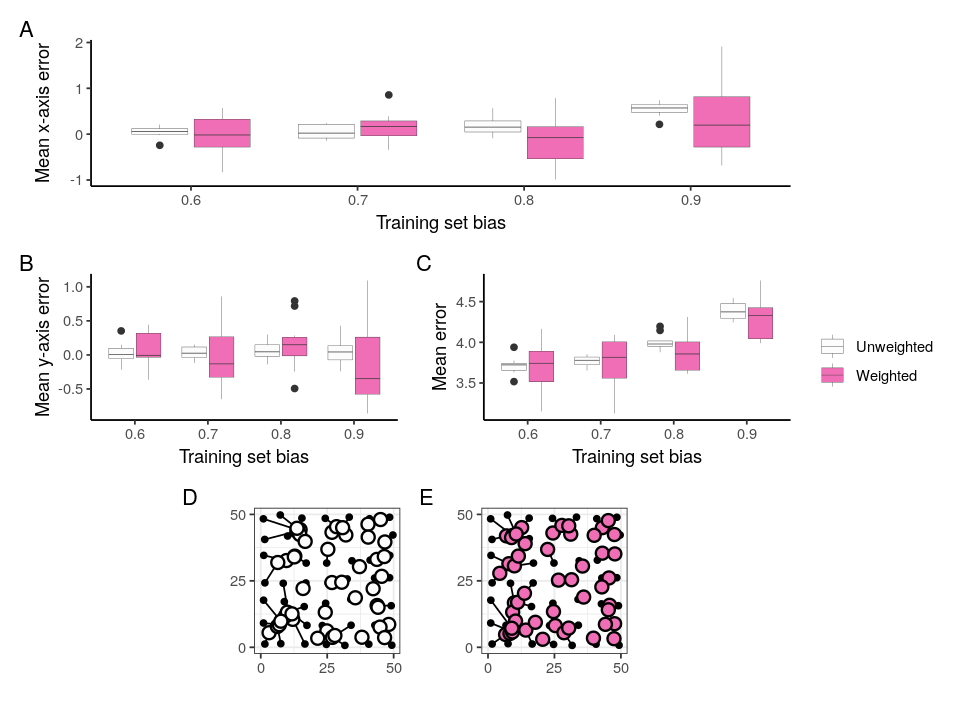

In [202]:
xplot / (yplot | eplot) / (unwpred | wpred) + plot_annotation(tag_level='A') + plot_layout(guides='collect')
ggsave(file.path(figdir,'weight_error.pdf'), width = 6.5, height = 6, units='in')

```
bw=1.4
lam = 3.981
```
no correlation with x axis error, negative correlation with y axis error :(


```
bw=5
lam = 0.1
```
more variance in prediction error but no correlation between skew and anything

```
bw = 0.25
lam = 1e-5
```

NICE!

In [203]:
err_df[(err_df$bw == 0.25) & (err_df$lm == 1e-5) & (err_df$skew == 0.9),]

bw,lm,skew,xerr_mean,xerr_median,err_mean,err_median,yerr_mean
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.25,1e-05,0.9,0.2948589,0.2739676,4.295774,3.753826,-0.1446397


In [206]:
lmdf[(lmdf$bw == 0.25) & (lmdf$lm == 1e-5),]

bw,lm,R,p
<dbl>,<dbl>,<dbl>,<dbl>
0.25,1e-05,0.1473159,0.1449892
